# Korean Drama Recommender

I love watching Korean Dramas so I wanted to see if I could make my own recommender. I took the categories from the dataset I thought were most interesting and did some EDA on them and then used ML to create the recommender.c

In [1]:
#import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('punkt', 'averaged_perception_tagger', 'wordnet', 'stopwords')
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
pip install fuzzywuzzy

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

## Preliminary Analysis

In [4]:
df = pd.read_csv('kdrama.csv')

In [5]:
df.head()

,Name,Aired Date,Year of release,Original Network,Aired On,Number of Episodes,Duration,Content Rating,Rating,Synopsis,Genre,Tags,Director,Screenwriter,Cast,Production companies,Rank
0,Move to Heaven,"May 14, 2021",2021,Netflix,Friday,10,52 min.,18+ Restricted (violence & profanity),9.2,Geu Roo is a young autistic man. He works for ...,"Life, Drama, Family","Autism, Uncle-Nephew Relationship, Death, Sava...",Kim Sung Ho,Yoon Ji Ryun,"Lee Je Hoon, Tang Jun Sang, Hong Seung Hee, Ju...","Page One Film, Number Three Pictures",#1
1,Flower of Evil,"Jul 29, 2020 - Sep 23, 2020",2020,tvN,"Wednesday, Thursday",16,1 hr. 10 min.,15+ - Teens 15 or older,9.1,Although Baek Hee Sung is hiding a dark secret...,"Thriller, Romance, Crime, Melodrama","Married Couple, Deception, Suspense, Family Se...","Kim Chul Gyu, Yoon Jong Ho",Yoo Jung Hee,"Lee Joon Gi, Moon Chae Won, Jang Hee Jin, Seo ...",Monster Union,#2
2,Hospital Playlist,"Mar 12, 2020 - May 28, 2020",2020,"Netflix, tvN",Thursday,12,1 hr. 30 min.,15+ - Teens 15 or older,9.1,The stories of people going through their days...,"Friendship, Romance, Life, Medical","Strong Friendship, Multiple Mains, Best Friend...",Shin Won Ho,Lee Woo Jung,"Jo Jung Suk, Yoo Yeon Seok, Jung Kyung Ho, Kim...","Egg Is Coming, CJ ENM",#3
3,Hospital Playlist 2,"Jun 17, 2021 - Sep 16, 2021",2021,"Netflix, tvN",Thursday,12,1 hr. 40 min.,15+ - Teens 15 or older,9.1,Everyday is extraordinary for five doctors and...,"Friendship, Romance, Life, Medical","Workplace, Strong Friendship, Best Friends, Mu...",Shin Won Ho,Lee Woo Jung,"Jo Jung Suk, Yoo Yeon Seok, Jung Kyung Ho, Kim...","Egg Is Coming, CJ ENM",#4
4,My Mister,"Mar 21, 2018 - May 17, 2018",2018,tvN,"Wednesday, Thursday",16,1 hr. 17 min.,15+ - Teens 15 or older,9.1,Park Dong Hoon is a middle-aged engineer who i...,"Psychological, Life, Drama, Family","Age Gap, Nice Male Lead, Strong Female Lead, H...","Kim Won Suk, Kim Sang Woo",Park Hae Young,"Lee Sun Kyun, IU, Park Ho San, Song Sae Byuk, ...",Chorokbaem Media,#5


In [6]:
#cleaning data by removing the # and converts to integers
df['Rank'] = df['Rank'].str.replace('#','').astype(int)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Name                  250 non-null    object 
 1   Aired Date            250 non-null    object 
 2   Year of release       250 non-null    int64  
 3   Original Network      250 non-null    object 
 4   Aired On              250 non-null    object 
 5   Number of Episodes    250 non-null    int64  
 6   Duration              250 non-null    object 
 7   Content Rating        245 non-null    object 
 8   Rating                250 non-null    float64
 9   Synopsis              250 non-null    object 
 10  Genre                 250 non-null    object 
 11  Tags                  250 non-null    object 
 12  Director              249 non-null    object 
 13  Screenwriter          249 non-null    object 
 14  Cast                  250 non-null    object 
 15  Production companies  2

In [8]:
df.isnull().sum().sort_values(ascending = False)

Content Rating          5
Production companies    2
Screenwriter            1
Director                1
Rank                    0
Number of Episodes      0
Aired Date              0
Year of release         0
Original Network        0
Aired On                0
Rating                  0
Duration                0
Synopsis                0
Genre                   0
Tags                    0
Cast                    0
Name                    0
dtype: int64

In [9]:
#drop missing
df.dropna(inplace=True)

In [10]:
#anything other than lower case az, upper AZ, numbers, and space get replaced with empty string
def clean_name(name):
    name = re.sub('[A-Za-z0-9]','', name)
    return name

In [11]:
#cleaning name
df["clean_name"] = df["Name"].apply(clean_name)

In [12]:
#extract hours and minutes from the duration column
hours = df['Duration'].str.extract(r'(\d+)\s*hr').astype(float)
minutes = df['Duration'].str.extract(r'(\d+)\s*min').astype(float)

#convert hours and minutes to minutes
hours = hours.fillna(0) * 60
minutes = minutes.fillna(0)

#calculate the total duration in minutes
total_duration = hours + minutes

#duration column should only be minutes now
df['Duration'] = total_duration

In [13]:
df.head(10)

,Name,Aired Date,Year of release,Original Network,Aired On,Number of Episodes,Duration,Content Rating,Rating,Synopsis,Genre,Tags,Director,Screenwriter,Cast,Production companies,Rank,clean_name
0,Move to Heaven,"May 14, 2021",2021,Netflix,Friday,10,52.0,18+ Restricted (violence & profanity),9.2,Geu Roo is a young autistic man. He works for ...,"Life, Drama, Family","Autism, Uncle-Nephew Relationship, Death, Sava...",Kim Sung Ho,Yoon Ji Ryun,"Lee Je Hoon, Tang Jun Sang, Hong Seung Hee, Ju...","Page One Film, Number Three Pictures",1,
1,Flower of Evil,"Jul 29, 2020 - Sep 23, 2020",2020,tvN,"Wednesday, Thursday",16,70.0,15+ - Teens 15 or older,9.1,Although Baek Hee Sung is hiding a dark secret...,"Thriller, Romance, Crime, Melodrama","Married Couple, Deception, Suspense, Family Se...","Kim Chul Gyu, Yoon Jong Ho",Yoo Jung Hee,"Lee Joon Gi, Moon Chae Won, Jang Hee Jin, Seo ...",Monster Union,2,
2,Hospital Playlist,"Mar 12, 2020 - May 28, 2020",2020,"Netflix, tvN",Thursday,12,90.0,15+ - Teens 15 or older,9.1,The stories of people going through their days...,"Friendship, Romance, Life, Medical","Strong Friendship, Multiple Mains, Best Friend...",Shin Won Ho,Lee Woo Jung,"Jo Jung Suk, Yoo Yeon Seok, Jung Kyung Ho, Kim...","Egg Is Coming, CJ ENM",3,
3,Hospital Playlist 2,"Jun 17, 2021 - Sep 16, 2021",2021,"Netflix, tvN",Thursday,12,100.0,15+ - Teens 15 or older,9.1,Everyday is extraordinary for five doctors and...,"Friendship, Romance, Life, Medical","Workplace, Strong Friendship, Best Friends, Mu...",Shin Won Ho,Lee Woo Jung,"Jo Jung Suk, Yoo Yeon Seok, Jung Kyung Ho, Kim...","Egg Is Coming, CJ ENM",4,
4,My Mister,"Mar 21, 2018 - May 17, 2018",2018,tvN,"Wednesday, Thursday",16,77.0,15+ - Teens 15 or older,9.1,Park Dong Hoon is a middle-aged engineer who i...,"Psychological, Life, Drama, Family","Age Gap, Nice Male Lead, Strong Female Lead, H...","Kim Won Suk, Kim Sang Woo",Park Hae Young,"Lee Sun Kyun, IU, Park Ho San, Song Sae Byuk, ...",Chorokbaem Media,5,
5,Reply 1988,"Nov 6, 2015 - Jan 16, 2016",2015,tvN,"Friday, Saturday",20,100.0,15+ - Teens 15 or older,9.1,"Five childhood friends, who all live in the sa...","Comedy, Romance, Youth, Family","Neighbors, Slice Of Life, Childhood Friends, M...","Shin Won Ho, Yoo Hak Chan",Lee Woo Jung,"Lee Hye Ri, Go Kyung Pyo, Ryu Joon Yeol, Park ...",CJ ENM,6,
6,Weak Hero Class 1,"Nov 18, 2022",2022,Wavve,Friday,8,40.0,18+ Restricted (violence & profanity),9.1,Yeon Shi Eun is a model student who ranks at t...,"Action, Youth, Drama\r","Bromance, Smart Male Lead, Violence, School Bu...",You Su Min,Jun Hee Han,"Park Ji Hoon, Choi Hyun Wook, Hong Kyung, Kim ...",PlayList Global,7,
7,Prison Playbook,"Nov 22, 2017 - Jan 18, 2018",2017,"Netflix, tvN","Wednesday, Thursday",16,92.0,15+ - Teens 15 or older,9.1,"Kim Je Hyuk, a famous baseball player, is arre...","Comedy, Crime, Life, Drama","Prison, Bromance, Wrongfully Accused, Life Les...",Shin Won Ho,"Jung Bo Hoon, Lee Woo Jung","Park Hae Soo, Jung Kyung Ho, Krystal Jung, Im ...",tvN,8,
8,Alchemy of Souls,"Jun 18, 2022 - Aug 28, 2022",2022,"Netflix, tvN","Saturday, Sunday",20,80.0,15+ - Teens 15 or older,9.0,Set in a fictional country called Daeho that d...,"Action, Historical, Romance, Fantasy","Magical Power, Supernatural, Transmigration, S...",Park Joon Hwa,"Hong Jung Eun, Hong Mi Ran","Lee Jae Wook, Jung So Min, Hwang Hyun Min, Shi...","Studio Dragon, High Quality",9,
9,Extraordinary Attorney Woo,"Jun 29, 2022 - Aug 18, 2022",2022,"ENA, Netflix","Wednesday, Thursday",16,77.0,15+ - Teens 15 or older,9.0,"Diagnosed with autism spectrum disorder, 27-ye...","Law, Romance, Life, Drama","Autistic Female Lead, Autism, Attorney Female...",Yoo In Shik,Moon Ji Won,"Park Eun Bin, Kang Tae Oh, Kang Ki Young, Jeon...","AStory, KT Studio Genie, Nangman Crew",10,


In [14]:
#extract numerical age from content rating column
df['Age Rating'] = df['Content Rating'].str.extract(r'(\d+)').astype(float)

In [15]:
#new column of age rating only has number
df.head()

,Name,Aired Date,Year of release,Original Network,Aired On,Number of Episodes,Duration,Content Rating,Rating,Synopsis,Genre,Tags,Director,Screenwriter,Cast,Production companies,Rank,clean_name,Age Rating
0,Move to Heaven,"May 14, 2021",2021,Netflix,Friday,10,52.0,18+ Restricted (violence & profanity),9.2,Geu Roo is a young autistic man. He works for ...,"Life, Drama, Family","Autism, Uncle-Nephew Relationship, Death, Sava...",Kim Sung Ho,Yoon Ji Ryun,"Lee Je Hoon, Tang Jun Sang, Hong Seung Hee, Ju...","Page One Film, Number Three Pictures",1,,18.0
1,Flower of Evil,"Jul 29, 2020 - Sep 23, 2020",2020,tvN,"Wednesday, Thursday",16,70.0,15+ - Teens 15 or older,9.1,Although Baek Hee Sung is hiding a dark secret...,"Thriller, Romance, Crime, Melodrama","Married Couple, Deception, Suspense, Family Se...","Kim Chul Gyu, Yoon Jong Ho",Yoo Jung Hee,"Lee Joon Gi, Moon Chae Won, Jang Hee Jin, Seo ...",Monster Union,2,,15.0
2,Hospital Playlist,"Mar 12, 2020 - May 28, 2020",2020,"Netflix, tvN",Thursday,12,90.0,15+ - Teens 15 or older,9.1,The stories of people going through their days...,"Friendship, Romance, Life, Medical","Strong Friendship, Multiple Mains, Best Friend...",Shin Won Ho,Lee Woo Jung,"Jo Jung Suk, Yoo Yeon Seok, Jung Kyung Ho, Kim...","Egg Is Coming, CJ ENM",3,,15.0
3,Hospital Playlist 2,"Jun 17, 2021 - Sep 16, 2021",2021,"Netflix, tvN",Thursday,12,100.0,15+ - Teens 15 or older,9.1,Everyday is extraordinary for five doctors and...,"Friendship, Romance, Life, Medical","Workplace, Strong Friendship, Best Friends, Mu...",Shin Won Ho,Lee Woo Jung,"Jo Jung Suk, Yoo Yeon Seok, Jung Kyung Ho, Kim...","Egg Is Coming, CJ ENM",4,,15.0
4,My Mister,"Mar 21, 2018 - May 17, 2018",2018,tvN,"Wednesday, Thursday",16,77.0,15+ - Teens 15 or older,9.1,Park Dong Hoon is a middle-aged engineer who i...,"Psychological, Life, Drama, Family","Age Gap, Nice Male Lead, Strong Female Lead, H...","Kim Won Suk, Kim Sang Woo",Park Hae Young,"Lee Sun Kyun, IU, Park Ho San, Song Sae Byuk, ...",Chorokbaem Media,5,,15.0


In [16]:
#creating New DataFrame with columns i think are most important
ndf = df[['Name', 'Year of release', 'Number of Episodes', 'Duration', 'Age Rating', 'Rating', 'Synopsis', 'Genre', 'Tags', 'Cast', 'Rank']] 

In [17]:
ndf.head()

,Name,Year of release,Number of Episodes,Duration,Age Rating,Rating,Synopsis,Genre,Tags,Cast,Rank
0,Move to Heaven,2021,10,52.0,18.0,9.2,Geu Roo is a young autistic man. He works for ...,"Life, Drama, Family","Autism, Uncle-Nephew Relationship, Death, Sava...","Lee Je Hoon, Tang Jun Sang, Hong Seung Hee, Ju...",1
1,Flower of Evil,2020,16,70.0,15.0,9.1,Although Baek Hee Sung is hiding a dark secret...,"Thriller, Romance, Crime, Melodrama","Married Couple, Deception, Suspense, Family Se...","Lee Joon Gi, Moon Chae Won, Jang Hee Jin, Seo ...",2
2,Hospital Playlist,2020,12,90.0,15.0,9.1,The stories of people going through their days...,"Friendship, Romance, Life, Medical","Strong Friendship, Multiple Mains, Best Friend...","Jo Jung Suk, Yoo Yeon Seok, Jung Kyung Ho, Kim...",3
3,Hospital Playlist 2,2021,12,100.0,15.0,9.1,Everyday is extraordinary for five doctors and...,"Friendship, Romance, Life, Medical","Workplace, Strong Friendship, Best Friends, Mu...","Jo Jung Suk, Yoo Yeon Seok, Jung Kyung Ho, Kim...",4
4,My Mister,2018,16,77.0,15.0,9.1,Park Dong Hoon is a middle-aged engineer who i...,"Psychological, Life, Drama, Family","Age Gap, Nice Male Lead, Strong Female Lead, H...","Lee Sun Kyun, IU, Park Ho San, Song Sae Byuk, ...",5


## Visualization

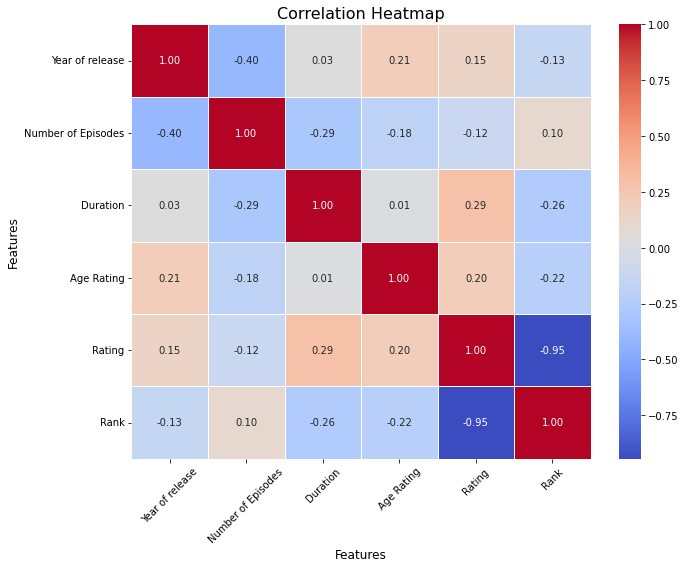

In [18]:
#kdramas seem to have less episodes as the years go on
# Set the figure size
plt.figure(figsize=(10, 8))

#Create the heatmap
sns.heatmap(ndf.corr(), annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f", cbar=True)

# Set plot title and axis labels
plt.title('Correlation Heatmap', fontsize=16)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Features', fontsize=12)

# Rotate x-axis tick labels for better readability
plt.xticks(rotation=45)

# Adjust the padding between subplots
plt.tight_layout()

# Show the plot
plt.show()

### Release Year

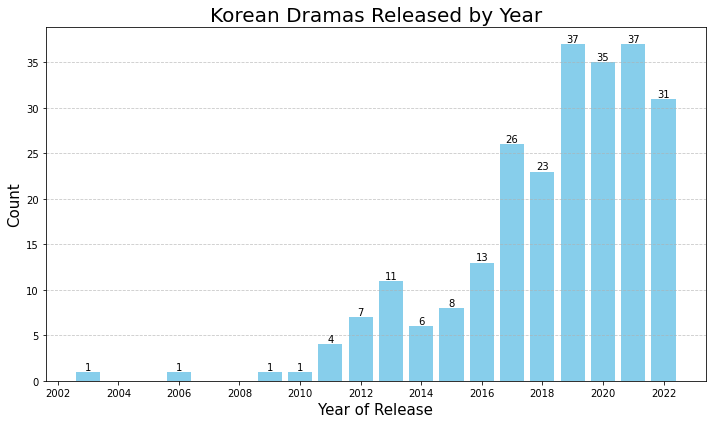

In [19]:
# Group the data by 'Year of release' and calculate the count
grouped_year = ndf.groupby('Year of release').size().reset_index().rename(columns={0: 'Count'})

# Create the bar graph
plt.figure(figsize=(10, 6))
plt.bar(data=grouped_year, x='Year of release', height='Count', color='skyblue')

# Plot title and axis labels
plt.title('Korean Dramas Released by Year', fontsize=20)
plt.xlabel('Year of Release', fontsize=15)
plt.ylabel('Count', fontsize=15)

# X-axis tick values
years = np.arange(2002, 2023, 2)
plt.xticks(years)

# Set a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels above each bar
for index, row in grouped_year.iterrows():
    plt.text(row['Year of release'], row['Count'], str(row['Count']), ha='center', va='bottom', fontsize=10)

# Adjust the padding between subplots
plt.tight_layout()

plt.show()


### Number of episodes

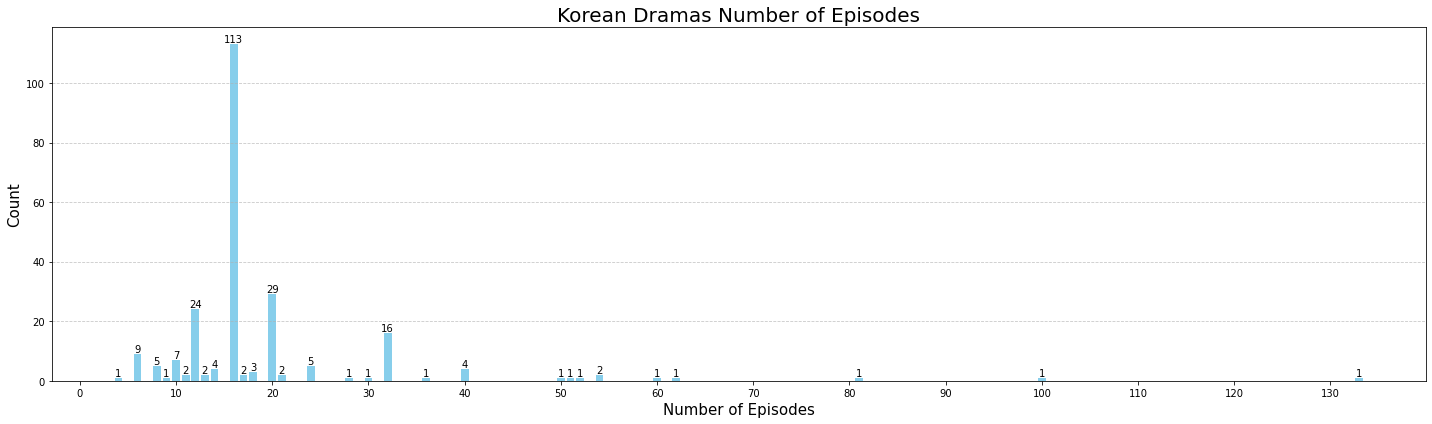

In [20]:
#group data by 'Number of Episodes' and calculate count
grouped_ep = ndf.groupby('Number of Episodes').size().reset_index().rename(columns={0: 'Count'})

#bar graph
plt.figure(figsize=(20, 6))
plt.bar(data=grouped_ep, x='Number of Episodes', height='Count', color='skyblue')

#plot title and axis labels
plt.title('Korean Dramas Number of Episodes', fontsize=20)
plt.xlabel('Number of Episodes', fontsize=15)
plt.ylabel('Count', fontsize=15)

#x-axis tick values
ep = np.arange(0, ndf['Number of Episodes'].max(), 10)
plt.xticks(ep)

#grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels above each bar
for index, row in grouped_ep.iterrows():
    plt.text(row['Number of Episodes'], row['Count'], str(row['Count']), ha='center', va='bottom', fontsize=10)
    
# Adjust the padding between subplots
plt.tight_layout()

plt.show()

### Duration

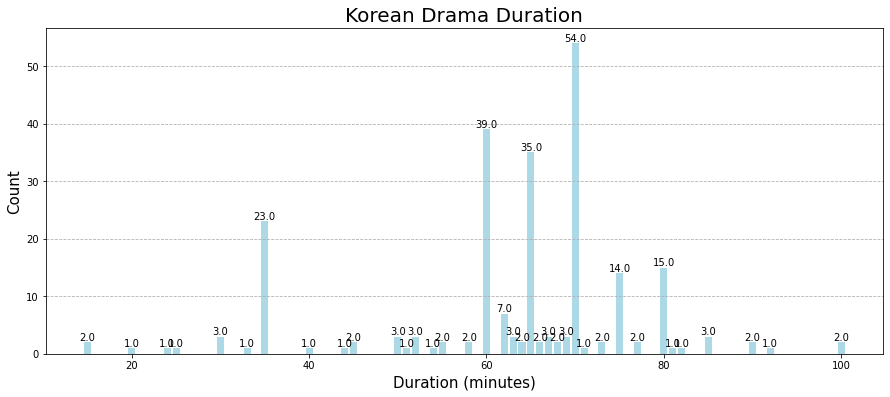

In [21]:
#grouped data by 'Duration' and calculate the count
grouped_dur = ndf.groupby('Duration').size().reset_index().rename(columns={0: 'Count'})

# Bar graph
plt.figure(figsize=(15, 6))
plt.bar(data=grouped_dur, x='Duration', height='Count', color='lightblue')

# Plot title and axis labels
plt.title('Korean Drama Duration', fontsize=20)
plt.xlabel('Duration (minutes)', fontsize=15)
plt.ylabel('Count', fontsize=15)

# Add value labels above each bar
for index, row in grouped_dur.iterrows():
    plt.text(row['Duration'], row['Count'], str(row['Count']), ha='center', va='bottom', fontsize=10)

# Add grid lines
plt.grid(axis='y', linestyle='--')
plt.show()

### Content Rating

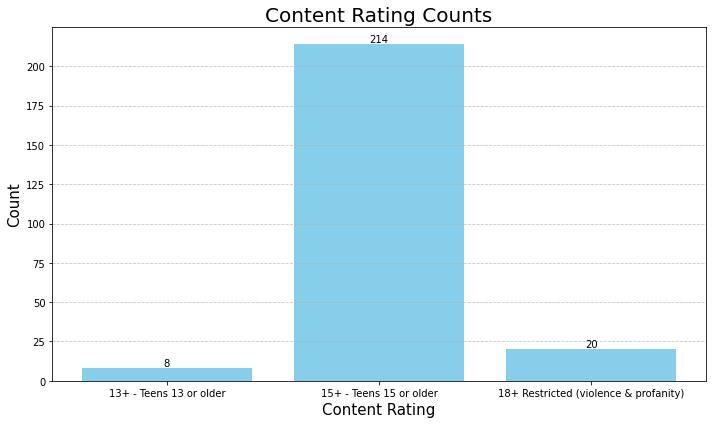

In [22]:
# Group the data by 'Content Rating' and calculate the count
grouped_rating = df.groupby('Content Rating').size().reset_index().rename(columns={0: 'Count'})

# Create the bar graph
plt.figure(figsize=(10, 6))
plt.bar(data=grouped_rating, x='Content Rating', height='Count', color='skyblue')

# Plot title and axis labels
plt.title('Content Rating Counts', fontsize=20)
plt.xlabel('Content Rating', fontsize=15)
plt.ylabel('Count', fontsize=15)

# Set a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels above each bar
for index, row in grouped_rating.iterrows():
    plt.text(row['Content Rating'], row['Count'], str(row['Count']), ha='center', va='bottom', fontsize=10)

# Adjust the padding between subplots
plt.tight_layout()

plt.show()


### Genres

In [23]:
#split genres and count per genre
genre_list = []
for genres in ndf['Genre'].str.split(", "):
    genre_list.extend(genres)

genre_counts = dict(Counter(genre_list))

#make df with all genres and their respective counts
genre_df = pd.DataFrame.from_dict(genre_counts, orient='index', columns=['Count'])
genre_df.sort_values(by='Count', ascending=False, inplace=True)
genre_df.head()

,Count
Romance,89
Thriller,71
Drama,69
Comedy,62
Mystery,61


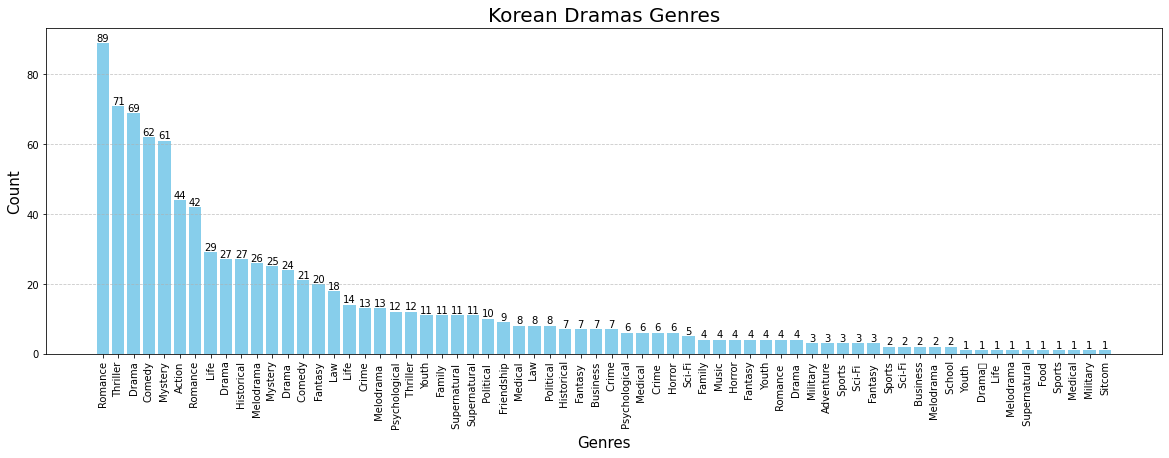

In [24]:
# Create the bar graph
plt.figure(figsize=(20, 6))
plt.bar(data=genre_df, x=genre_df.index, height='Count', color='skyblue')

# Plot title and axis labels
plt.title('Korean Dramas Genres', fontsize=20)
plt.xlabel('Genres', fontsize=15)
plt.ylabel('Count', fontsize=15)

# Rotate x-axis labels
plt.xticks(rotation=90)

# Set a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels above each bar
for index, row in genre_df.iterrows():
    plt.text(index, row['Count'], str(row['Count']), ha='center', va='bottom', fontsize=10)

plt.show()


### Tags

In [25]:
#split tags and count per tag like the genres
tag_list = []
for tag in ndf['Tags'].str.split(", "):
    tag_list.extend(tag)

tag_counts = dict(Counter(tag_list))

# Create a DataFrame with all genres and their counts
tag_df = pd.DataFrame.from_dict(tag_counts, orient='index', columns=['Count'])
tag_df.sort_values(by='Count', ascending=False, inplace=True)
tag_df.head()

,Count
Strong Female Lead,95
Smart Female Lead,47
Nice Male Lead,45
Smart Male Lead,45
Murder,41


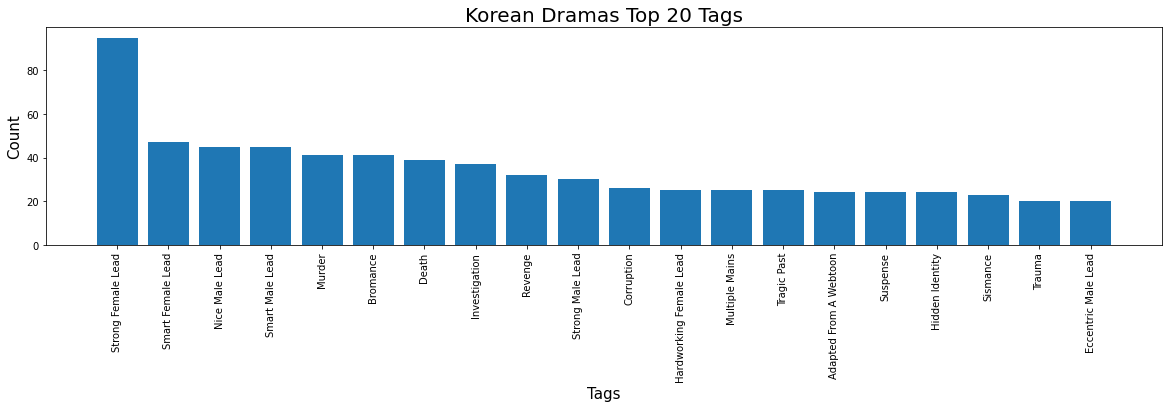

In [26]:
#bar graph
plt.figure(figsize=(20, 4))
plt.bar(data=tag_df.head(20), x = tag_df.iloc[:20].index, height='Count')

#plot title and axis labels
plt.title('Korean Dramas Top 20 Tags', fontsize=20)
plt.xlabel('Tags', fontsize=15)
plt.ylabel('Count', fontsize=15)

#rotate x-axis labels
plt.xticks(rotation=90)

plt.show()

In [27]:
#lowest and highest rating scores
ndf['Rating'].min(), ndf['Rating'].max()

(8.3, 9.2)

### Cast

In [28]:
#splitting cast members of each drama
cast_list = list()

for casts in ndf['Cast'].to_list():
    casts = casts.split(", ")
    for a in casts:
        cast_list.append(a)
        
#putting each individual cast member and their appearance in a df
cast_df = pd.DataFrame.from_dict(Counter(cast_list),orient = 'index').rename(columns = {0:'Appearance'})
cast_df.sort_values(by='Appearance',ascending = False,inplace = True)
cast_df.head()

,Appearance
Lee Joon Hyuk,8
Shin Hye Sun,7
Ahn Bo Hyun,7
Lee Jong Suk,6
Uhm Ki Joon,6


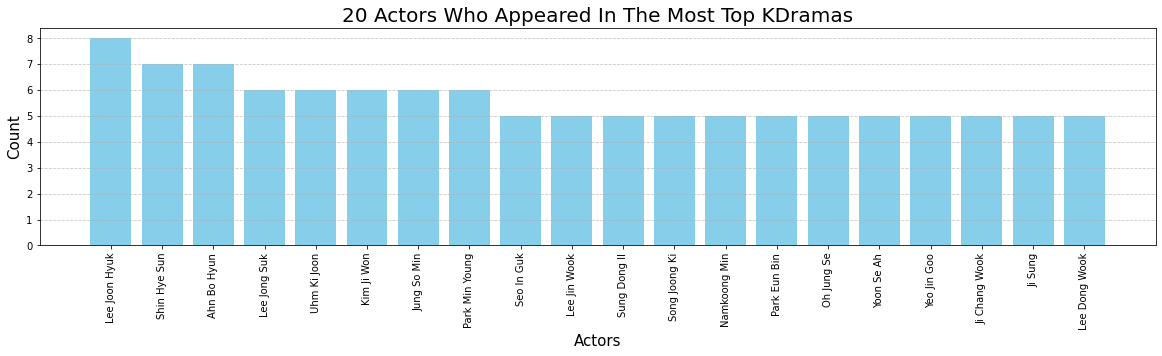

In [29]:
# Create the bar graph
plt.figure(figsize=(20, 4))
plt.bar(data=cast_df.head(20), x=cast_df.iloc[:20].index, height='Appearance', color='skyblue')

# Plot title and axis labels
plt.title('20 Actors Who Appeared In The Most Top KDramas', fontsize=20)
plt.xlabel('Actors', fontsize=15)
plt.ylabel('Count', fontsize=15)

# Rotate x-axis labels
plt.xticks(rotation=90)

# Set a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

## 3 Recommendation systems

In [30]:
#list of column names from to consider for creating combined features
features = ['Duration','Synopsis','Cast','Genre','Tags']

In [31]:
#ensures that 'Number of Episodes' is treated as a string when combining features later
ndf['Number of Episodes'] = ndf['Number of Episodes'].astype(str)

#concatenate values from the 'Synopsis', 'Genre', and 'Tags' columns, separated by a space, and assigns the concatenated values to the 'combined_features' column
ndf['combined_features'] = ndf['Synopsis'] + " " + ndf['Genre'] + " " + ndf['Tags']

In [32]:
#convert a collection of text documents into a matrix of token counts.
cv = CountVectorizer()

#transforms the text data into a matrix of token counts, where each row represents a document and each column represents a unique word
count_matrix = cv.fit_transform(ndf['combined_features'])

#cosine similarity measures the similarity between each pair of documents in the 'count_matrix'
cosine_sim = cosine_similarity(count_matrix)

### KDrama title searcher

In [33]:
#search for drama with the keyword
def kdrama_available(key):
    
    keyword = key
    
    print("Drama with keyword: [{}]".format(keyword))
    
    for i, mov in enumerate(ndf[ndf['Name'].str.contains(keyword)]['Name'].to_list()):
        print("{}) {} ".format(i+1,mov))

In [34]:
#searching for 'Extraordinary Attorney Woo'
kdrama_available('Crash Landing On You')

Drama with keyword: [Crash Landing On You]


In [35]:
#tfdif is an importance score of each word in a document considering its frequency and rarity 
tfdif_vector = TfidfVectorizer(stop_words = 'english')

#tfidf_matrix contains the tfdif scores for each word in each synopsis.
tfidf_matrix = tfdif_vector.fit_transform(ndf['Synopsis'])

#represents the pairwise similarity scores
sim_matrix = linear_kernel(tfidf_matrix, tfidf_matrix)

#'Name' column is index. can map a drama name to its corresponding index in ndf. drop_duplicates ensures that each drama name has a unique index
indicies = pd.Series(ndf.index, index = ndf['Name']).drop_duplicates()

### Recommendation based of cosine similarity

In [36]:
#finds similar dramas based on the cosine similarity matrix, and prints the recommendations along with their similarity scores. If the user's input is not found in the database, it displays an error message.
def kdrama_recommendation(mov,sim_num = 5):

    user_choice = mov
    
    try:
        ref_index = ndf[ndf['Name'].str.contains(user_choice, case = False)].index[0]

        similar_movies = list(enumerate(cosine_sim[ref_index]))

        sorted_simmilar_movies = sorted(similar_movies, key = lambda x: x[1], reverse = True)[1:]

        print('\nRecomended K Drama for [{}]'.format(user_choice))
        print('-'*(24 + len(user_choice)))

        for i, element in enumerate(sorted_simmilar_movies):
            similar_movie_id = element[0]
            similar_movie_title = ndf['Name'].iloc[similar_movie_id]
            s_score = element[1]
            print('{:40} -> {:.3f}'.format(similar_movie_title, s_score))

            if i > sim_num:
                break
    except IndexError:
        print("\n[{}] is not in our database!".format(user_choice))
        print("We couldn't recommend anyting...Sorry...")

In [37]:
kdrama_recommendation('Extraordinary Attorney Woo')


Recomended K Drama for [Extraordinary Attorney Woo]
--------------------------------------------------
Law School                               -> 0.486
Run On                                   -> 0.485
Mother                                   -> 0.476
Touch Your Heart                         -> 0.473
Juvenile Justice                         -> 0.471
Welcome 2 Life                           -> 0.468
Lawless Lawyer                           -> 0.466


### Recommendation based of similarity matrix

In [38]:
#similar dramas based on the similarity matrix
def content_based_recommender(title, sim_scores = sim_matrix):
    idx = indicies[title]
    
    sim_scores = list(enumerate(sim_matrix[idx]))
    
    sim_scores = sorted(sim_scores, key = lambda x : x[1], reverse = True)
    
    sim_scores = sim_scores[1:11]
    
    drama_score = list()
    for score in sim_scores:
        drama_score.append(score[1])
    
    kdrama_indices = [i[0] for i in sim_scores]
    
    kdrama_name = ndf['Name'].iloc[kdrama_indices]
    
    print('\nRecomended KDrama for [{}]'.format(title))
    print('-'*(24 + len(title)))
    
    for score,name in list(zip(drama_score,kdrama_name)):
        print("{:30} -> {:.3f}".format(name,score))

In [39]:
#reducing words to their base or root form
lemmatizer = WordNetLemmatizer()

#remove stop words(a, the, is, etc.) because no significant meaning
stop_words = set(stopwords.words('english'))

#filter out non-verb words during text analysis tasks
VERB_CODES = {'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'}

In [49]:
content_based_recommender('Goblin')


Recomended KDrama for [Goblin]
------------------------------
Are You Human Too?             -> 0.114
One Ordinary Day               -> 0.103
My Unfamiliar Family           -> 0.098
Weak Hero Class 1              -> 0.092
Lost                           -> 0.090
Oh My Venus                    -> 0.087
Light on Me                    -> 0.086
Terius Behind Me               -> 0.082
Bulgasal: Immortal Souls       -> 0.081
Again My Life                  -> 0.080


In [41]:
#clean and normalize the text data from 'Synopsis' column of ndf
def preprocess_sentences(text):
    text = text.lower()
    temp_sent =[]
    words = nltk.word_tokenize(text)
    tags = nltk.pos_tag(words)
    for i, word in enumerate(words):
        if tags[i][1] in VERB_CODES: 
              lemmatized = lemmatizer.lemmatize(word, 'v')
        else:
              lemmatized = lemmatizer.lemmatize(word)
        if lemmatized not in stop_words and lemmatized.isalpha():
              temp_sent.append(lemmatized)

    finalsent = ' '.join(temp_sent)
    finalsent = finalsent.replace("n't", " not")
    finalsent = finalsent.replace("'m", " am")
    finalsent = finalsent.replace("'s", " is")
    finalsent = finalsent.replace("'re", " are")
    finalsent = finalsent.replace("'ll", " will")
    finalsent = finalsent.replace("'ve", " have")
    finalsent = finalsent.replace("'d", " would")
    return finalsent

ndf_copy = ndf.copy()
ndf_copy['synopsis_processed'] = ndf_copy['Synopsis'].apply(preprocess_sentences)
ndf_copy['synopsis_processed'].head()

0    geu roo young autistic man work father busines...
1    although baek hee sung hide dark secret surrou...
2    story people go day seemingly ordinary actuall...
3    everyday extraordinary five doctor patient ins...
4    park dong hoon engineer marry attorney kang yo...
Name: synopsis_processed, dtype: object

In [42]:
#find similar documents based on their cosine similarity values
tfdifvec = TfidfVectorizer()
tfdif_drama_processed = tfdifvec.fit_transform((ndf_copy['synopsis_processed']))
ndf_cosine = cosine_similarity(tfdif_drama_processed,tfdif_drama_processed)

### Recommendation based of similarity values

In [43]:
#picks indices of the top 10 KDramas with the highest cosine similarity values.
indices = pd.Series(ndf_copy['Name'])
  
def recommendations(title, cosine_sim = ndf_cosine):
    recommended_movies = []
    index = indices[indices == title].index[0]
    similarity_scores = pd.Series(cosine_sim[index]).sort_values(ascending = False)
    top_10_movies = list(similarity_scores.iloc[1:11].index)
    for i in top_10_movies:
        recommended_movies.append(list(ndf_copy['Name'].index)[i])
        
    print('\nRecomended KDrama for [{}]'.format(title))
    print('-'*(24 + len(title)))
    
    for index in recommended_movies:
        print(ndf_copy.iloc[index]['Name'])

In [48]:
recommendations("Crash Landing on You")


Recomended KDrama for [Crash Landing on You]
--------------------------------------------
Mr. Queen
Kill Me, Heal Me
Twenty-Five Twenty-One
A Business Proposal
Mr. Sunshine
Ugly Alert
Kairos
Chicago Typewriter
Voice 3: City of Accomplices
Nine: Nine Times Time Travel


In [45]:
def recommendationZ(title, cosine_sim=ndf_cosine):
    recommended_movies = []
    lower_title = title.lower()  # Convert search input to lowercase

    # Find fuzzy matches and get the best match
    best_match = process.extractOne(lower_title, ndf_copy['Name'], scorer=fuzz.token_sort_ratio)
    if best_match[1] < 70:  # Set a threshold for fuzzy matching confidence
        print("Can't find that KDrama. Please check the spelling, upper/lower casing, or try a different title.")
        return
    
    index = indices[indices == best_match[0]].index[0]
    similarity_scores = pd.Series(cosine_sim[index]).sort_values(ascending=False)
    top_10_movies = list(similarity_scores.iloc[1:11].index)
    for i in top_10_movies:
        recommended_movies.append(list(ndf_copy['Name'].index)[i])
        
    print('\nRecommended KDramas for [{}]'.format(title))
    print('-' * (24 + len(title)))
    
    for index in recommended_movies:
        print(ndf_copy.iloc[index]['Name'])


In [46]:
recommendationZ("Crush landing onyou")


Recommended KDramas for [Crush landing onyou]
-------------------------------------------
Mr. Queen
Kill Me, Heal Me
Twenty-Five Twenty-One
A Business Proposal
Mr. Sunshine
Ugly Alert
Kairos
Chicago Typewriter
Voice 3: City of Accomplices
Nine: Nine Times Time Travel


In [ ]:
def recommendationZ(cosine_sim=ndf_cosine):
    recommended_movies = []
    
    # Prompt user for KDrama title
    title = input("Enter the KDrama title: ")
    lower_title = title.lower()  # Convert search input to lowercase

    # Find fuzzy matches and get the best match
    best_match = process.extractOne(lower_title, ndf_copy['Name'], scorer=fuzz.token_sort_ratio)
    if best_match[1] < 70:  # Set a threshold for fuzzy matching confidence
        print("Can't find that KDrama. Please check the spelling, upper/lower casing, or try a different title.")
        return
    
    index = indices[indices == best_match[0]].index[0]
    similarity_scores = pd.Series(cosine_sim[index]).sort_values(ascending=False)
    top_10_movies = list(similarity_scores.iloc[1:11].index)
    for i in top_10_movies:
        recommended_movies.append(list(ndf_copy['Name'].index)[i])
        
    print('\nRecommended KDramas for [{}]'.format(title))
    print('-' * (24 + len(title)))
    
    for index in recommended_movies:
        print(ndf_copy.iloc[index]['Name'])

In [52]:
recommendationZ()

Text(value='', description='KDrama Title:', placeholder='Enter the KDrama title')